## Definition

### Problem Statement  

The goal is to forecast the demand for bikes in dependency of weather conditions like outside temperature and calendric informations e.g. holidays. These information and the demand structure is provided in a set with two years of daily historic data.  
The demand is given as the total daily demand and as a split for registered users and casual users. To increase the quality of the prediction registered user demand and casual user demand will be predicted separately in step two.  
To make predictions machine learning is used to train regressors. Scikit-Learn recommends a support vector regressor (SVR) for this kind of problem and data amount. In addition a deep neuronal network (DNN) regressor is trained for comparison. To find the hyper-parameters for these regressors grid search and randomized search are utilized. Due to the small dataset cross validation is applied.    

> http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html  
> http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR  
> https://github.com/tensorflow/skflow/blob/master/g3doc/api_docs/python/estimators.md  
> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html  
> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from math import sqrt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Analysis

In [2]:
# Fetching Dataset

bike_data = pd.read_csv("day.csv", header=0)

print("Data read successfully!")

Data read successfully!


In [3]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Data Exploration

In [4]:
# Extracting

feature_cols = bike_data.columns[:-3]  # all columns but last are features
target_col = bike_data.columns[-1]  # last column is the target

print ("Feature column(s):\n{}\n".format(feature_cols))
print ("Target column:\n{}".format(target_col))

Feature column(s):
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

Target column:
cnt


In [5]:
#### Function to Calculate Profit

In [6]:
def profit(y,y_cap):
    return 3 * np.minimum(y[::1], y_cap[::1]) - 2 * y_cap[::1]
    

#### Function to Convert from percentage to Actual Prediction

In [7]:
def convertToPrediction(data,percentage_predictions):
    demand = np.around(data + (np.multiply(data, percentage_predictions)/100))
    demand[demand <0 ] = 0
    return demand

#### RMSLE Scorer
One common way to evaluate regression model is through calculating MSE or RMSE. In this particular project , the metric to evaluate our model is Root Mean Square Logarithmic Error (RMSLE). RMSLE is particularly helpful when you want to penalize an under-predicted estimate greater than an over-predicted estimate.

In [26]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Base Model

#### For the base model the demand for today is the previous days demand. 

In [8]:
y_actual = bike_data[target_col][365:731]  # corresponding targets
y_actual = y_actual.reset_index(drop = True)

In [9]:
y_staged = y_actual.copy()

In [10]:
data = []
data.insert(0, bike_data[target_col][364])
data.insert(0, bike_data[target_col][363])

In [11]:
y_predicted_df = pd.concat([pd.DataFrame(data), y_staged], ignore_index=True)

In [12]:
y_predicted_df.drop(y_predicted_df.tail(2).index,inplace=True)

In [13]:
y_predicted = y_predicted_df[0]


##### Calculate Base Model Profit

In [14]:
print(profit(y_actual,y_predicted).sum())

1442972


####  Dataset with percentage change

In [15]:
data = pd.read_csv("processed_Data.csv", header=0)
data['instant'] = data['instant'] % 30
X_raw_train = data[0:359]
X_raw_test  = data[359:]

In [16]:
cols =[
       "season__1","season__2","season__3","season__4","season__5",
       "weathersit__1","weathersit__2","weathersit__3","weathersit__4","weathersit__5",
        "cnt__1",
        "atemp","hum","windspeed",
        "mnth","instant","holiday","weekday","workingday",
        "moving_avg_weekly_cnt"]     

In [17]:
X_train = X_raw_train[cols].values.tolist()
y_train_df = X_raw_train[['demand_pc_inc']]
y_train = y_train_df['demand_pc_inc'].tolist()

In [18]:
X_test = X_raw_test[cols].values.tolist()
y_test_df = X_raw_test[['demand_pc_inc']]
y_test = y_test_df['demand_pc_inc'].tolist()

In [19]:
data_cnt = data['cnt']

In [20]:
actual_predictions = data_cnt[359:].values

In [21]:
y_for_calculations = data_cnt[357:723].values

### Algorithms and Techniques

In [22]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [23]:
#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification
 

## Methodology

### Implementation

The regressors are trained using randomized search and cross-validation to identify the area of the best parameters. Then a grid search is used to tune parameter values of the regressor functions.

> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html  
> http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.RandomizedSearchCV.html

In [30]:
from sklearn.linear_model import LinearRegression
# Initialize logistic regression model
lModel = LinearRegression()
# Train the model
lModel.fit(X = X_train,y = y_train)
# Make predictions
preds = lModel.predict(X= X_test)
print ("RMSLE Value: ",rmsle(y_test,preds))

RMSLE Value:  1.5792007461493136


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
##Profit Calculation for pct approach
model_predictions = convertToPrediction(y_for_calculations,preds)
print(profit(actual_predictions,model_predictions).sum())

891359.0


[Text(0.5,1,'Test Set Distribution')]

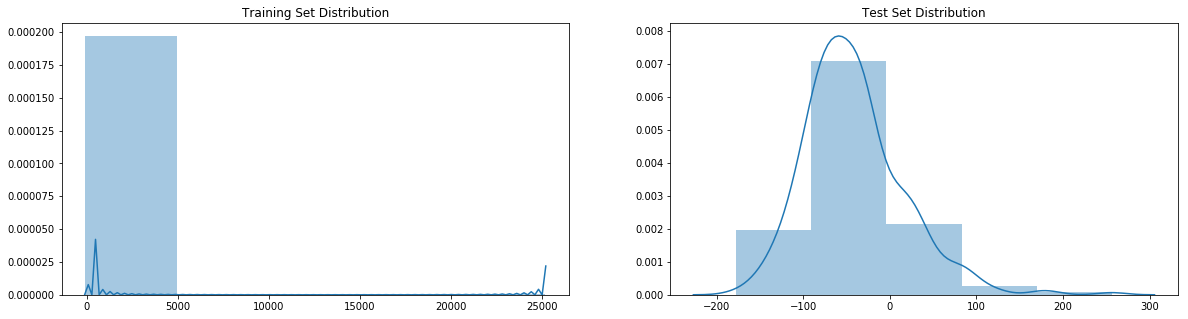

In [35]:
import seaborn as sn
predsTest = lModel.predict(X=X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(20,5)
sn.distplot(y_test,ax=ax1,bins=5)
sn.distplot(predsTest,ax=ax2,bins=5)
ax1.set(title="Training Set Distribution")
ax2.set(title="Test Set Distribution")

#### SVM Regressor

In [38]:
# Training SVR
svr = SVR()
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [39]:
# Validation SVR

pred_svr = svr.predict(X_test)
score_svr = r2_score(y_test, pred_svr)
rmse_svr = sqrt(mean_squared_error(y_test, pred_svr))

print("Score SVR: %f" % score_svr)
print("RMSE SVR: %f" % rmse_svr)

Score SVR: -0.003305
RMSE SVR: 1318.397271


In [40]:
model_predictions = convertToPrediction(y_for_calculations,pred_svr)
print(profit(actual_predictions,model_predictions).sum())

1438256.0


In [41]:
# Tuning SVR with GridSearch

tuned_parameters = [{'C': [0.1,0.5,1,10,100,1000, 3000, 10000], 
                     'kernel': ['linear', 'rbf']}
                   ]

#svr_tuned = GridSearchCV(SVR (C=1), param_grid = tuned_parameters, scoring = 'mean_squared_error') #default 3-fold cross-validation, score method of the estimator
svr_tuned_GS = GridSearchCV(SVR (C=1), param_grid = tuned_parameters, scoring = 'r2', n_jobs=-1) #default 3-fold cross-validation, score method of the estimator

svr_tuned_GS.fit(X_train, y_train)

print (svr_tuned_GS)
print ('\n' "Best parameter from grid search: " + str(svr_tuned_GS.best_params_) +'\n')

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 0.5, 1, 10, 100, 1000, 3000, 10000], 'kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

Best parameter from grid search: {'C': 0.1, 'kernel': 'linear'}



In [42]:
svr_tuned_pred_GS = svr_tuned_GS.predict(X_test)

score_svr_tuned_GS = r2_score(y_test, svr_tuned_pred_GS)
rmse_svr_tuned_GS = sqrt(mean_squared_error(y_test, svr_tuned_pred_GS))

print("SVR Results\n")

print("Score SVR: %f" % score_svr)
print("Score SVR tuned GS: %f" % score_svr_tuned_GS)

print("\nRMSE SVR: %f" % rmse_svr)
print("RMSE SVR tuned GS: %f" % rmse_svr_tuned_GS)

SVR Results

Score SVR: -0.003305
Score SVR tuned GS: 0.008924

RMSE SVR: 1318.397271
RMSE SVR tuned GS: 1310.337901


In [43]:
svr_tuned_pred_GS


##Profit Calculation for pct approach
model_predictions = convertToPrediction(y_for_calculations,svr_tuned_pred_GS)
print(profit(actual_predictions,model_predictions).sum())



1504657.0


In [50]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions))

RMSLE Value:  0.5609165789602343


### MLP Regressor

In [76]:
from sklearn.neural_network import MLPRegressor

In [77]:
import logging
from concurrent.futures import ThreadPoolExecutor, wait
from time import time
from typing import List

In [120]:
bike_model = MLPRegressor(hidden_layer_sizes=(5,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=15000,
                                       learning_rate_init=0.01,
                                       alpha=0.01)

In [121]:
start_time = int(time() * 1000)
bike_model.fit(X_train, y_train)
end_time = int(time() * 1000)
logging.debug('Finished training universal model')
logging.debug('Training took {} ms'.format(end_time - start_time)) 

In [122]:
pred_dnn = bike_model.predict(X_test)

In [123]:
model_predictions_dnn = convertToPrediction(y_for_calculations,pred_dnn)

In [124]:
print(profit(actual_predictions,model_predictions_dnn).sum())

1450481.0


In [125]:
print ("RMSLE Value: ",rmsle(actual_predictions,model_predictions_dnn))

RMSLE Value:  0.49808837294227704


#### KNN Regressor

In [51]:
### KNN Regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import pipeline,metrics,grid_search


regressor = KNeighborsRegressor()
estimator_knn = pipeline.Pipeline(steps = [       
    ('model_fitting', regressor)
    ]
)
estimator_knn.fit(X_train, y_train)
pred_knn = estimator_knn.predict(X_test)
model_predictions_knn = convertToPrediction(y_for_calculations,pred_knn)
print(profit(actual_predictions,model_predictions_knn).sum())

1445710.0
